<a href="https://colab.research.google.com/github/TacticalNuclearRaccoon/Survival_Analysis_League_of_Legends/blob/main/FeatureExtraction_ModelSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Survival analysis League of Legends

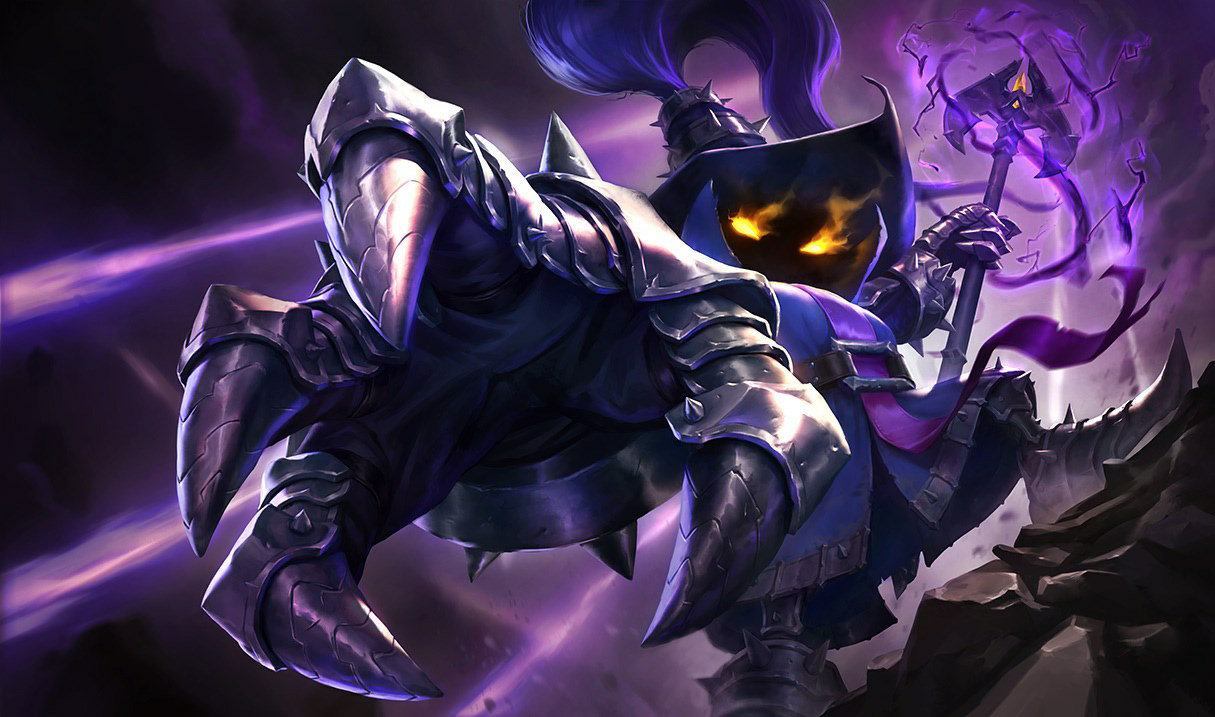

## Introduction
League of Legends (LoL) is a multiplayer online battle arena video game developed and published by Riot Games for Microsoft Windows and macOS. In League of Legends, players assume the role of a "champion" with unique abilities and battle against a team of other player- or computer-controlled champions. The goal is usually to destroy the opposing team's "Nexus", a structure that lies at the heart of a base protected by defensive structures, although other distinct game modes exist as well with varying objectives, rules, and maps. Each League of Legends match is discrete, with all champions starting off relatively weak but increasing in strength by accumulating items and experience over the course of the game. This dataset contains the first 10min. stats of approx. 10k ranked games (SOLO QUEUE) from a high ELO (DIAMOND I to MASTER). Players have roughly the same level. There are 19 features per team (38 in total) collected after 10min in-game. This includes kills, deaths, gold, experience, level… It's up to you to do some feature engineering to get more insights. The column blueWins is the target value (the value we are trying to predict). A value of 1 means the blue team has won. 
Here, our aim is to predict which features are more correlated with winning.

In [46]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
#Importing data
from google.colab import files
uploaded = files.upload()

Saving high_diamond_ranked_10min.csv to high_diamond_ranked_10min.csv


In [3]:
#Loading data
dataset = pd.read_csv('high_diamond_ranked_10min.csv')
dataset.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


## About the dataset
This .csv file contains approx. 10k ranked games (from high Diamond to low Master). Each row is a unique game and features have been collected after the first 10 minutes of the game. Column gameId can be used to collect more attributes from Riot API, **column blueWins is the target.**

## Exploratory data analysis

In [7]:
# check missing values and data type
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [8]:
# creating a copy for "cleaned data"
dataset_clean = dataset.copy()

In [9]:
# Drop some columns. (some are repeated, some are not necessarily useful)
cols = ['gameId', 'redFirstBlood', 'redKills', 'redEliteMonsters', 'redDragons','redTotalMinionsKilled',
       'redTotalJungleMinionsKilled', 'redGoldDiff', 'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin', 'redHeralds',
       'blueGoldDiff', 'blueExperienceDiff', 'blueCSPerMin', 'blueGoldPerMin', 'blueTotalMinionsKilled']
dataset_clean = dataset_clean.drop(cols, axis = 1)

In [10]:
dataset_clean.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalJungleMinionsKilled,redWardsPlaced,redWardsDestroyed,redDeaths,redAssists,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience
0,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,36,15,6,9,8,0,16567,6.8,17047
1,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,43,12,1,5,2,1,17620,6.8,17438
2,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,46,15,3,7,14,0,17285,6.8,17254
3,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,55,15,2,4,10,0,16478,7.0,17961
4,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,57,17,2,6,7,0,17404,7.0,18313


In [11]:
dataset_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   blueWins                      9879 non-null   int64  
 1   blueWardsPlaced               9879 non-null   int64  
 2   blueWardsDestroyed            9879 non-null   int64  
 3   blueFirstBlood                9879 non-null   int64  
 4   blueKills                     9879 non-null   int64  
 5   blueDeaths                    9879 non-null   int64  
 6   blueAssists                   9879 non-null   int64  
 7   blueEliteMonsters             9879 non-null   int64  
 8   blueDragons                   9879 non-null   int64  
 9   blueHeralds                   9879 non-null   int64  
 10  blueTowersDestroyed           9879 non-null   int64  
 11  blueTotalGold                 9879 non-null   int64  
 12  blueAvgLevel                  9879 non-null   float64
 13  blu

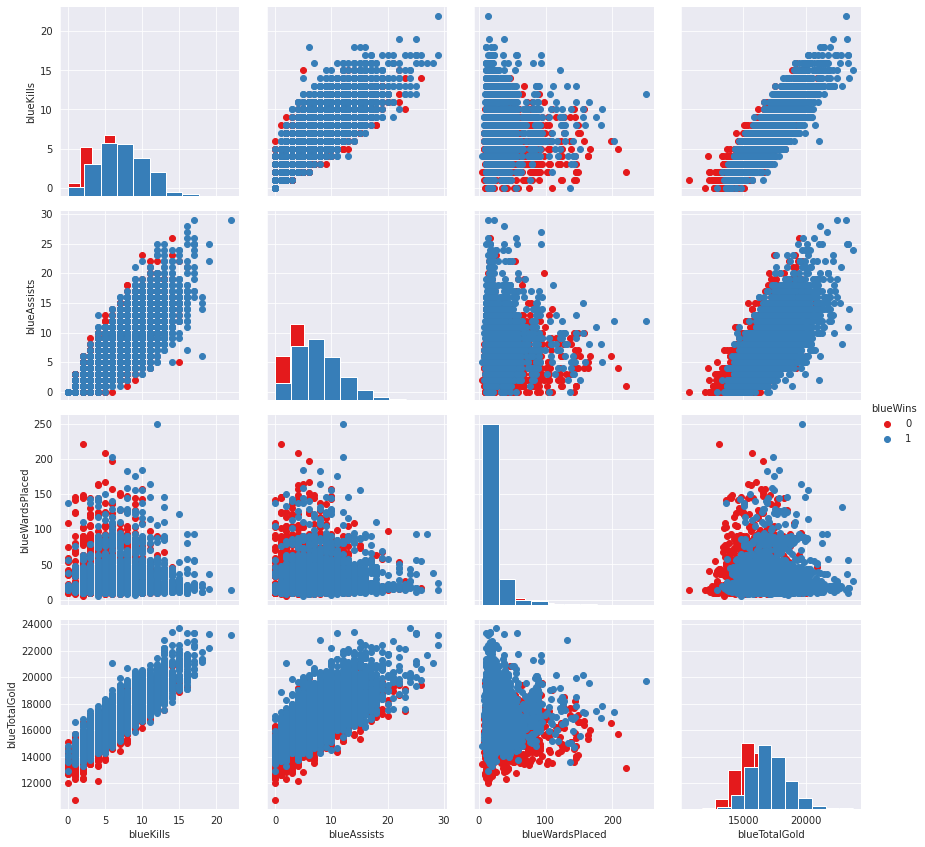

In [13]:
# Pairplots for the relationships between parameters of blue team features
g = sns.PairGrid(data=dataset_clean, vars=['blueKills', 'blueAssists', 'blueWardsPlaced', 'blueTotalGold'], hue='blueWins', height=3, palette='Set1')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

A lot of features are highly correlated.

## Correlation Matrix

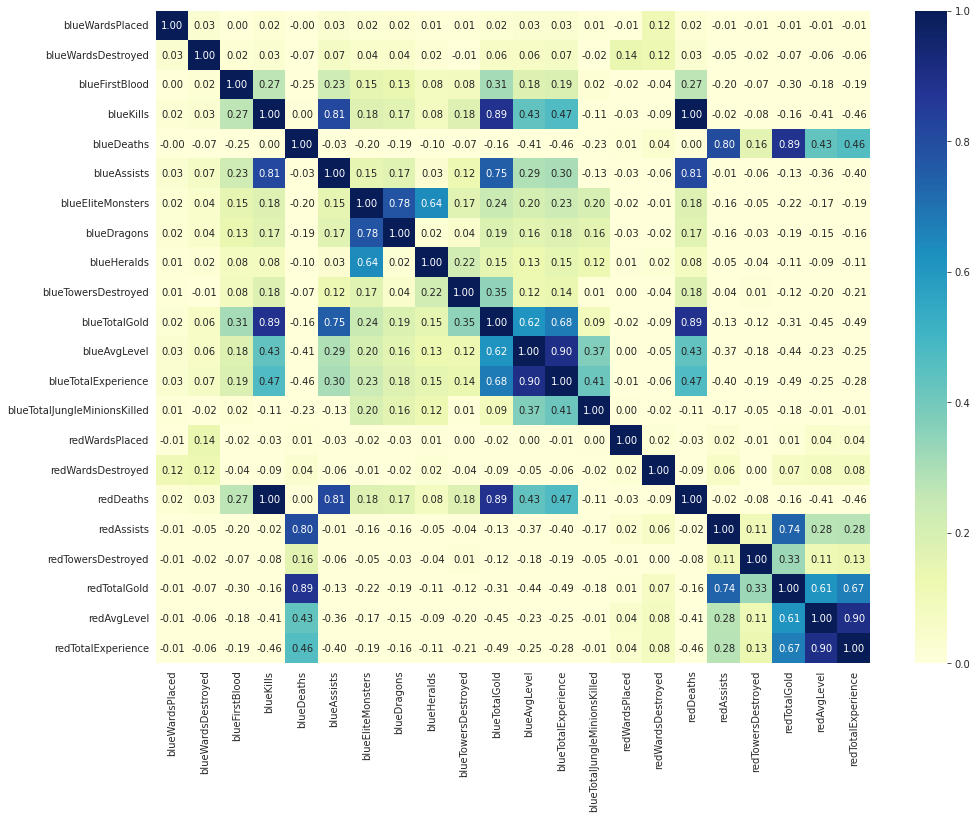

In [14]:
plt.figure(figsize=(16, 12))
sns.heatmap(dataset_clean.drop('blueWins', axis=1).corr(), cmap='YlGnBu', annot=True, fmt='.2f', vmin=0);

Further cleaning the dataset to avoid colinearity. For this, we can:

* Remove some of the highly correlated independent variables.
* Linearly combine the independent variables, such as adding them together.
* Perform an analysis designed for highly correlated variables, such as principal components analysis or partial least squares regression.

We will simply do the 1st one.

In [15]:
cols = ['blueAvgLevel', 'redWardsPlaced', 'redWardsDestroyed', 'redDeaths', 'redAssists', 'redTowersDestroyed',
       'redTotalExperience', 'redTotalGold', 'redAvgLevel']
dataset_clean = dataset_clean.drop(cols, axis=1)

In [16]:
dataset_clean.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueTotalExperience,blueTotalJungleMinionsKilled
0,0,28,2,1,9,6,11,0,0,0,0,17210,17039,36
1,0,12,1,0,5,5,5,0,0,0,0,14712,16265,43
2,0,15,0,0,7,11,4,1,1,0,0,16113,16221,46
3,0,43,1,0,4,5,5,1,0,1,0,15157,17954,55
4,0,75,4,0,6,6,6,0,0,0,0,16400,18543,57


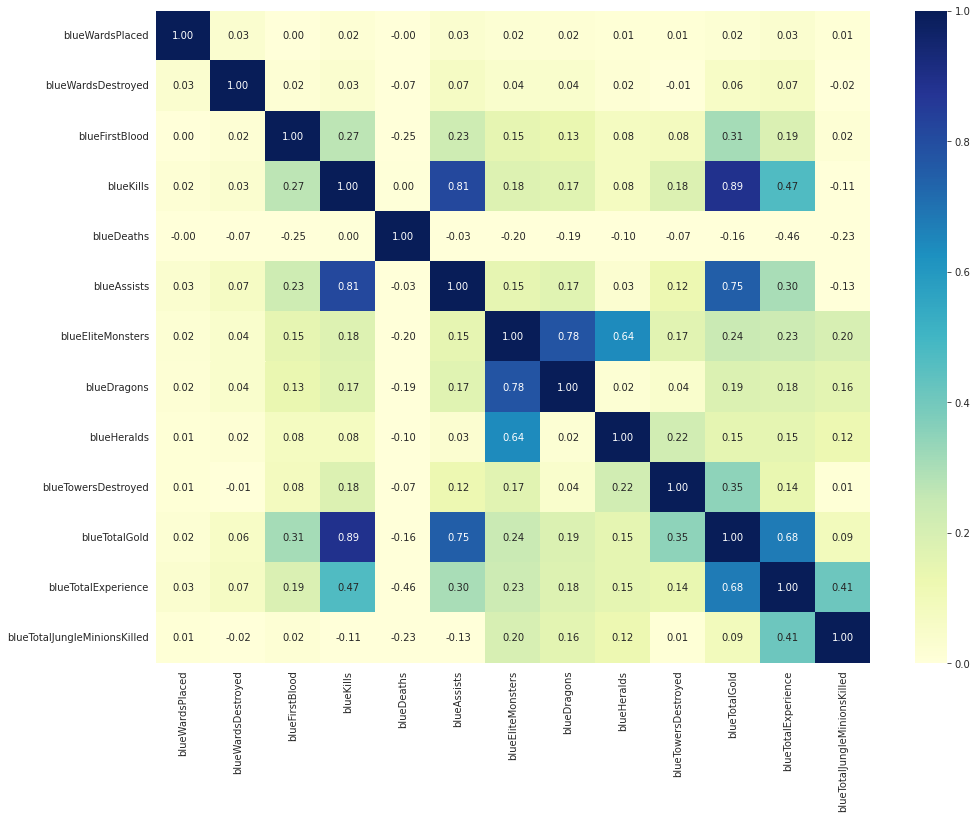

In [17]:
plt.figure(figsize=(16, 12))
sns.heatmap(dataset_clean.drop('blueWins', axis=1).corr(), cmap='YlGnBu', annot=True, fmt='.2f', vmin=0);

In [19]:
# Next let's drop the columns has little correlation with bluewins
corr_list = dataset_clean[dataset_clean.columns[1:]].apply(lambda x: x.corr(dataset_clean['blueWins']))
cols = []
for col in corr_list.index:
    if (corr_list[col]>0.2 or corr_list[col]<-0.2):
        cols.append(col)
cols

['blueFirstBlood',
 'blueKills',
 'blueDeaths',
 'blueAssists',
 'blueEliteMonsters',
 'blueDragons',
 'blueTotalGold',
 'blueTotalExperience']

In [20]:
dataset_clean = dataset_clean[cols]
dataset_clean.head()

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience
0,1,9,6,11,0,0,17210,17039
1,0,5,5,5,0,0,14712,16265
2,0,7,11,4,1,1,16113,16221
3,0,4,5,5,1,0,15157,17954
4,0,6,6,6,0,0,16400,18543


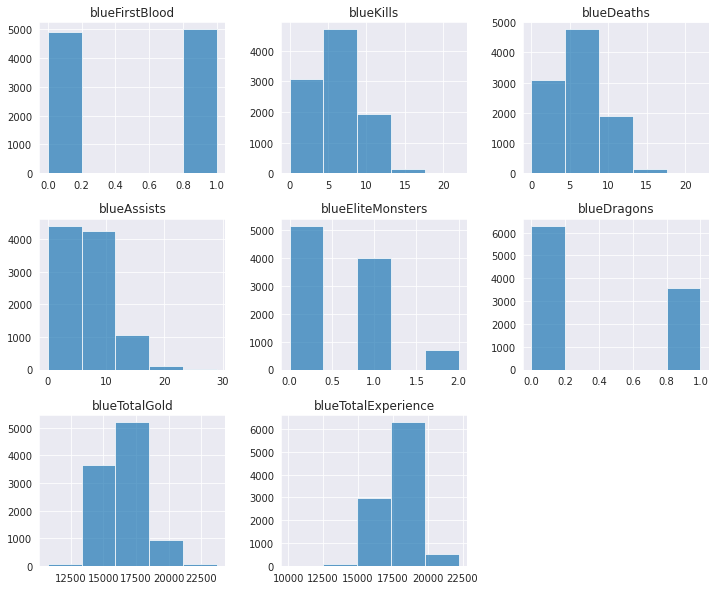

In [21]:
dataset_clean.hist(alpha = 0.7, figsize=(12,10), bins=5);

Saving the cleaned dataset to google drive so I don't need to do that again if I switch to R for the assignment: 

In [24]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [26]:
dataset_clean.to_csv('Clean_LoL_data.csv')
!cp Clean_LoL_data.csv "drive/My Drive/"

## Model Selection

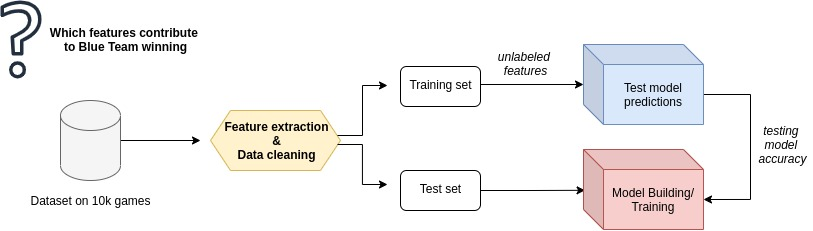

In [29]:
# train test split scale the set
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
X = dataset_clean
y = dataset['blueWins']
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Naive Bayes**

In [30]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# fit the model
clf_nb = GaussianNB()
clf_nb.fit(X_train, y_train)

pred_nb = clf_nb.predict(X_test)

# get the accuracy score
acc_nb = accuracy_score(pred_nb, y_test)
print(acc_nb)

0.7176113360323887


### **Decision tree**

In [31]:
# fit the decision tree model
from sklearn import tree
from sklearn.model_selection import GridSearchCV

tree = tree.DecisionTreeClassifier()

# search the best params
grid = {'min_samples_split': [5, 10, 20, 50, 100]},

clf_tree = GridSearchCV(tree, grid, cv=5)
clf_tree.fit(X_train, y_train)

pred_tree = clf_tree.predict(X_test)

# get the accuracy score
acc_tree = accuracy_score(pred_tree, y_test)
print(acc_tree)

0.6923076923076923


### **Random forest**

In [32]:
# fit the model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

# search the best params
grid = {'n_estimators':[100,200,300,400,500], 'max_depth': [2, 5, 10]}

clf_rf = GridSearchCV(rf, grid, cv=5)
clf_rf.fit(X_train, y_train)

pred_rf = clf_rf.predict(X_test)
# get the accuracy score
acc_rf = accuracy_score(pred_rf, y_test)
print(acc_rf)

0.729757085020243


## **KNN**

In [33]:
# fit the model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier() 

# search the best params
grid = {"n_neighbors":np.arange(1,100)}
clf_knn = GridSearchCV(knn, grid, cv=5)
clf_knn.fit(X_train,y_train) 

# get accuracy score
pred_knn = clf_knn.predict(X_test) 
acc_knn = accuracy_score(pred_knn, y_test)
print(acc_knn)

0.7171052631578947


## **Logistic Regression**

In [35]:
# fit logistic regression model
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression()
lm.fit(X_train, y_train)

# get accuracy score
pred_lm = lm.predict(X_test)
acc_lm = accuracy_score(pred_lm, y_test)
print(acc_lm)

0.7302631578947368


## Comparing the models

In [36]:
data_dict = {'Naive Bayes': [acc_nb], 'DT': [acc_tree], 'Random Forest': [acc_rf], 'Logistic Regression': [acc_lm], 'K_nearest Neighbors': [acc_knn]}
df_c = pd.DataFrame.from_dict(data_dict, orient='index', columns=['Accuracy Score'])
print(df_c)

                     Accuracy Score
Naive Bayes                0.717611
DT                         0.692308
Random Forest              0.729757
Logistic Regression        0.730263
K_nearest Neighbors        0.717105


**Random forest** and **Logistic resgression** models perform the best (highest accuracies).

Recall & Precision of the best performing models:

**Logistic regression:**

In [38]:
# recall and precision
from sklearn.metrics import recall_score, precision_score

# params for lm 
recall_lm = recall_score(pred_lm, y_test, average = None)
precision_lm = precision_score(pred_lm, y_test, average = None)
print('precision score for logistic regression: {}\n recall score for logistic regression:{}'.format(precision_lm, recall_lm))

precision score for logistic regression: [0.72736521 0.73313192]
 recall score for logistic regression:[0.72959184 0.73092369]


**Random forest:**

In [40]:
# params for rf
recall_rf = recall_score(pred_rf, y_test, average = None)
precision_rf = precision_score(pred_rf, y_test, average = None)
print('precision score for random forest: {}\n recall score for random forest:{}'.format(precision_rf, recall_rf))

precision score for random forest: [0.73652085 0.72306143]
 recall score for random forest:[0.72472472 0.73490276]


Choosing Logistic regression.

In [41]:
lm.coef_

array([[ 0.09774618,  1.61664247, -4.8653555 , -0.2625516 ,  0.30534437,
         0.2947777 ,  5.35409797,  1.74486909]])

In [42]:
np.exp(lm.coef_)

array([[1.10268286e+00, 5.03615284e+00, 7.70908711e-03, 7.69086679e-01,
        1.35709227e+00, 1.34282781e+00, 2.11473136e+02, 5.72515194e+00]])

In [44]:
coef_data = np.concatenate((lm.coef_, np.exp(lm.coef_)),axis=0)
coef_df = pd.DataFrame(data=coef_data, columns=dataset_clean.columns).T.reset_index().rename(columns={'index': 'Var', 0: 'coef', 1: 'oddRatio'})
coef_df.sort_values(by='coef', ascending=False)

,Var,coef,oddRatio
6,blueTotalGold,5.354098,211.473136
7,blueTotalExperience,1.744869,5.725152
1,blueKills,1.616642,5.036153
4,blueEliteMonsters,0.305344,1.357092
5,blueDragons,0.294778,1.342828
0,blueFirstBlood,0.097746,1.102683
3,blueAssists,-0.262552,0.769087
2,blueDeaths,-4.865356,0.007709


In [45]:
#saving this to drive
coef_df.to_csv('Coefs_LoL.csv')
!cp Coefs_LoL.csv "drive/My Drive/"